import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import numpy as np
import os
import optuna
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split


print(torch.__version__)          # This should show 2.4.1 for PyTorch
print(torchvision.__version__)    # This should show 0.17.1 or similar for Torchvision
print(torch.cuda.is_available())  # This should return True if CUDA is working correctly
print('test')
print('lucas line23')


# Step 1: Import data

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import numpy as np
import os
import optuna
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
import datetime
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

from torch.utils.tensorboard import SummaryWriter

defaultDir = 'runs/Chal/' # default dir

# Initialize a SummaryWriter to save logs
writer = SummaryWriter(defaultDir + 'AppliedOPT') # name of run


print(torch.__version__)          # This should show 2.4.1 for PyTorch
print(torchvision.__version__)    # This should show 0.17.1 or similar for Torchvision
print(torch.cuda.is_available())  # This should return True if CUDA is working correctly


/opt/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.4.1+cu121
0.19.1+cu121
True


In [2]:
# %load_ext tensorboard

# %tensorboard --logdir runs
%matplotlib inline


stap1

# Step 2: Flatting the data to a 1D array (vector)

In [3]:
from pathlib import Path
import pandas as pd

def load_labeled_data_pathlib(root_dir, valid_extensions=('.png', '.jpg', '.jpeg')):
    root = Path(root_dir)
    data = []

    for label_dir in root.iterdir():
        if label_dir.is_dir():
            label = label_dir.name
            for image_path in label_dir.iterdir():
                if image_path.suffix.lower() in valid_extensions:
                    data.append({'image_path': str(image_path), 'label': label})

    df = pd.DataFrame(data)
    return df

# Specify the path to your dataset directory
# dataset_path = 'Fruit dataset/'  # Deepnote approach
dataset_path = 'fruitDataset' # local approach

# Load the labeled data
df_labeled = load_labeled_data_pathlib(dataset_path)

# Display the first few rows to verify
print("First 5 entries in the labeled data:")
print(df_labeled.head())


First 5 entries in the labeled data:
                        image_path label
0   fruitDataset/Kiwi/Kiwi0059.png  Kiwi
1  fruitDataset/Kiwi/Kiwi00465.png  Kiwi
2  fruitDataset/Kiwi/Kiwi00336.png  Kiwi
3  fruitDataset/Kiwi/Kiwi00408.png  Kiwi
4  fruitDataset/Kiwi/Kiwi00491.png  Kiwi


In [4]:
# --- Testing the Labeled Data ---

# a. Inspect the DataFrame
print("DataFrame Information:")
print(df_labeled.info())

print("\nMissing Values in Each Column:")
print(df_labeled.isnull().sum())

print("\nFirst 5 Entries:")
print(df_labeled.head())

# b. Analyze Label Distribution
label_counts = df_labeled['label'].value_counts()

print("\nLabel Distribution:")
print(label_counts)


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1500 non-null   object
 1   label       1500 non-null   object
dtypes: object(2)
memory usage: 23.6+ KB
None

Missing Values in Each Column:
image_path    0
label         0
dtype: int64

First 5 Entries:
                        image_path label
0   fruitDataset/Kiwi/Kiwi0059.png  Kiwi
1  fruitDataset/Kiwi/Kiwi00465.png  Kiwi
2  fruitDataset/Kiwi/Kiwi00336.png  Kiwi
3  fruitDataset/Kiwi/Kiwi00408.png  Kiwi
4  fruitDataset/Kiwi/Kiwi00491.png  Kiwi

Label Distribution:
label
Kiwi      500
Apple     500
Banana    500
Name: count, dtype: int64


/tmp/ipykernel_2173381/293778534.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


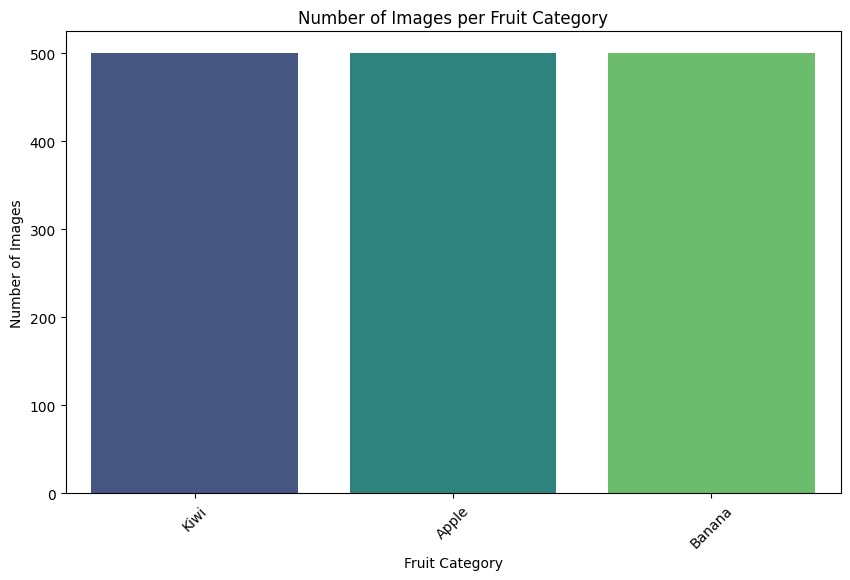

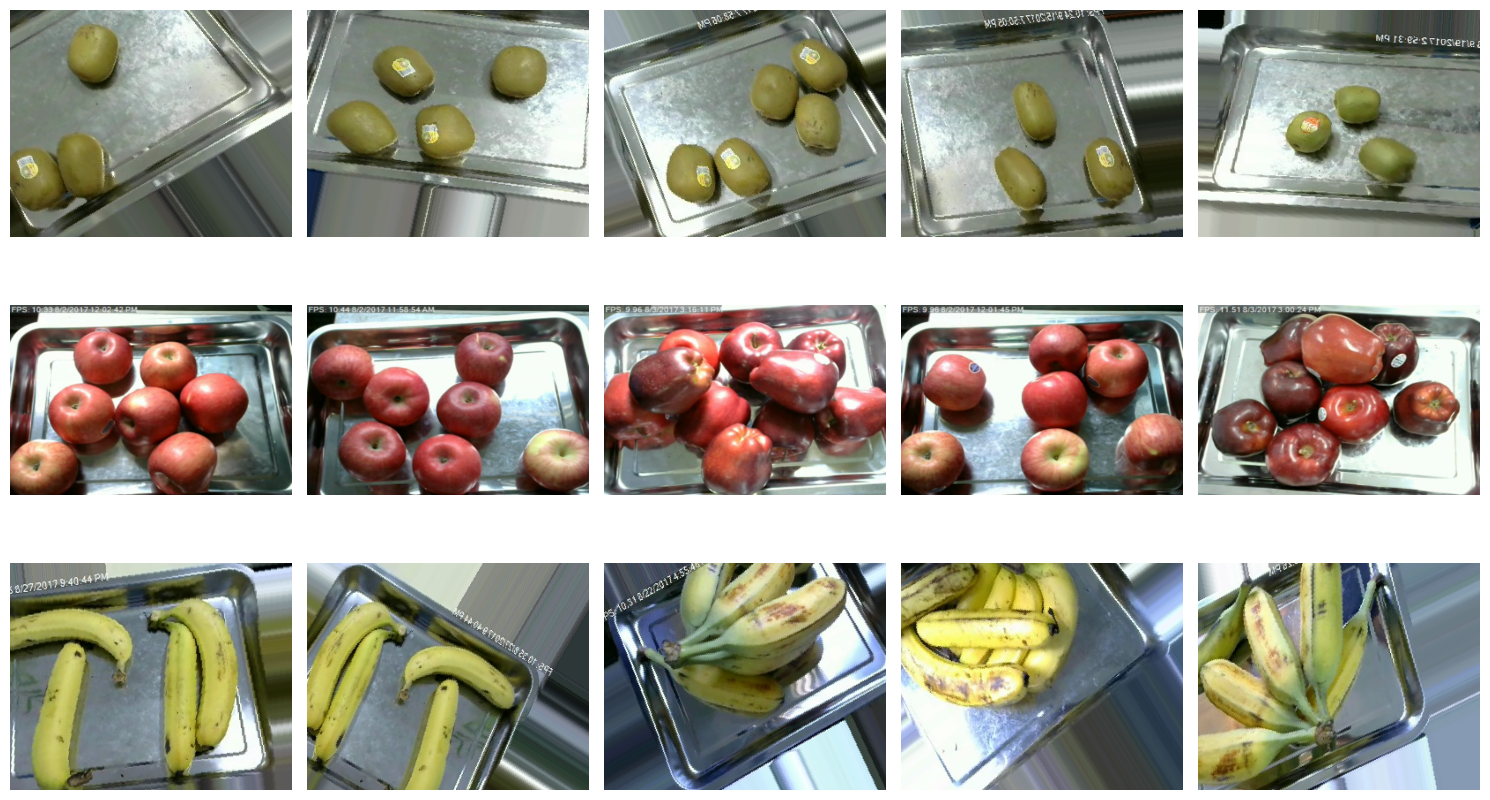


All image paths are valid.


In [5]:

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Number of Images per Fruit Category')
plt.xlabel('Fruit Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# c. Visualize Sample Images
def display_sample_images(df, num_samples=5):
    """
    Displays a sample of images from each label category.

    Parameters:
    - df (pd.DataFrame): The labeled DataFrame containing image paths and labels.
    - num_samples (int): Number of samples to display per category.
    """
    labels = df['label'].unique()
    plt.figure(figsize=(15, 3 * len(labels)))

    for i, label in enumerate(labels):
        label_df = df[df['label'] == label].sample(n=min(num_samples, len(df[df['label'] == label])), random_state=42)
        for j, (idx, row) in enumerate(label_df.iterrows()):
            plt_idx = i * num_samples + j + 1
            plt.subplot(len(labels), num_samples, plt_idx)
            try:
                img = Image.open(row['image_path'])
                plt.imshow(img)
                plt.axis('off')
                if j == 0:
                    plt.ylabel(label, size='large')
            except Exception as e:
                print(f"Error loading image {row['image_path']}: {e}")
    plt.tight_layout()
    plt.show()

display_sample_images(df_labeled, num_samples=5)

# d. Verify File Paths
def verify_image_paths(df):
    """
    Verifies that all image paths in the DataFrame exist.

    Parameters:
    - df (pd.DataFrame): The labeled DataFrame containing image paths.

    Returns:
    - missing_paths (list): A list of image paths that do not exist.
    """
    missing_paths = []
    for path in df['image_path']:
        if not os.path.exists(path):
            missing_paths.append(path)
    return missing_paths

missing_images = verify_image_paths(df_labeled)

if missing_images:
    print(f"\nThere are {len(missing_images)} missing image files:")
    for path in missing_images:
        print(path)
else:
    print("\nAll image paths are valid.")


Training Set Label Distribution:
label
Apple     400
Kiwi      400
Banana    400
Name: count, dtype: int64


/tmp/ipykernel_2173381/2482291102.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


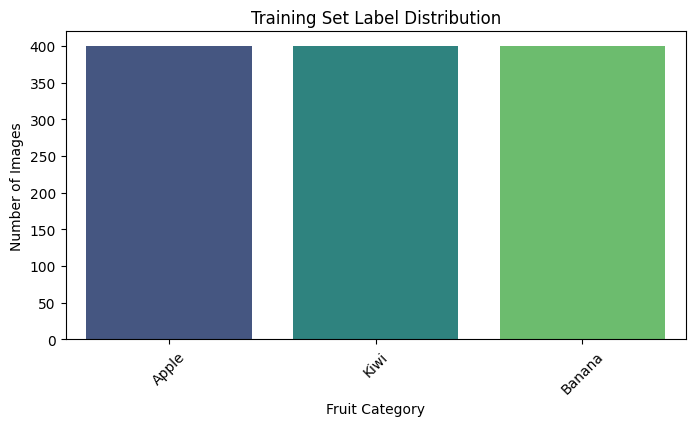


Validation Set Label Distribution:
label
Banana    100
Apple     100
Kiwi      100
Name: count, dtype: int64


/tmp/ipykernel_2173381/2482291102.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


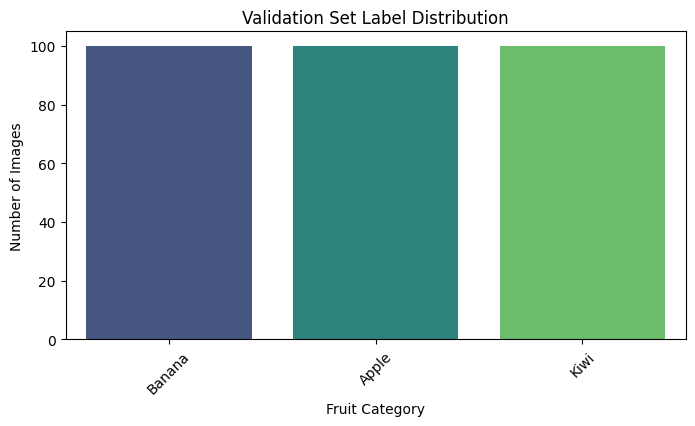


Train and Validation sets have been successfully created and saved.


In [6]:

# 4. Perform the Train-Validation Split
def split_train_val(df, train_size=0.8, random_state=42):
    train_df, val_df = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df['label']
    )
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True)

# Execute the split
train_df, val_df = split_train_val(df_labeled, train_size=0.8, random_state=42)

# 5. Verify the Split
def print_label_distribution(df, name):
    print(f"\n{name} Set Label Distribution:")
    label_counts = df['label'].value_counts()
    print(label_counts)
    
    # Optional: Plot the distribution
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.title(f'{name} Set Label Distribution')
    plt.xlabel('Fruit Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

# Print distributions
print_label_distribution(train_df, 'Training')
print_label_distribution(val_df, 'Validation')

# 6. (Optional) Save the Split DataFrames to CSV Files
# This can be useful for record-keeping or if you need to load them later without re-splitting
#train_df.to_csv('train_data.csv', index=False)
#val_df.to_csv('val_data.csv', index=False)

print("\nTrain and Validation sets have been successfully created and saved.")


In [7]:
train_df.head()

,image_path,label
0,fruitDataset/Apple/Apple 0358.png,Apple
1,fruitDataset/Apple/Apple 0207.png,Apple
2,fruitDataset/Apple/Apple 028.png,Apple
3,fruitDataset/Apple/Apple 0302.png,Apple
4,fruitDataset/Kiwi/Kiwi00380.png,Kiwi


In [8]:
val_df.head()
len(val_df)

300

In [9]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
train_df['label'] = label_encoder.fit_transform(train_df['label'])
val_df['label'] = label_encoder.fit_transform(val_df['label'])

# Display the first few rows to verify
# train_df.head(10)
val_df.head(10)


,image_path,label
0,fruitDataset/Banana/Banana0374.png,1
1,fruitDataset/Apple/Apple 0277.png,0
2,fruitDataset/Apple/Apple 0215.png,0
3,fruitDataset/Banana/Banana0456.png,1
4,fruitDataset/Kiwi/Kiwi0059.png,2
5,fruitDataset/Banana/Banana0243.png,1
6,fruitDataset/Kiwi/Kiwi00192.png,2
7,fruitDataset/Kiwi/Kiwi00196.png,2
8,fruitDataset/Banana/Banana0368.png,1
9,fruitDataset/Kiwi/Kiwi00474.png,2


In [10]:

IMAGE_WIDTH = 128    # You can choose other sizes like 128, 224, etc.
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3  # RGB channels


def load_and_process_image(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT)):
    try:
        # Open the image file
        with Image.open(image_path) as img:
            # Convert image to RGB (in case it's grayscale or RGBA)
            img = img.convert('RGB')
            # Resize the image
            img = img.resize(target_size)
            # Convert the image to a numpy array
            img_array = np.array(img)
            # Flatten the image
            img_flat = img_array.flatten()
            # Normalize pixel values to [0, 1]
            img_normalized = img_flat / 255.0
            return img_normalized
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


In [11]:
# Function to process a DataFrame and return feature array and labels
def preprocess_dataframe(df):
    X = []
    y = []
    
    for index, row in df.iterrows():
        image = load_and_process_image(row['image_path'])
        if image is not None:
            X.append(image)
            y.append(row['label'])
    
    X = np.array(X)
    y = np.array(y)
    return X, y



In [12]:
# Preprocess training data
X_train, y_train = preprocess_dataframe(train_df)
print(f"Processed training data shape: {X_train.shape}")

# Preprocess validation data
X_val, y_val = preprocess_dataframe(val_df)
print(f"Processed validation data shape: {X_val.shape}")


Processed training data shape: (1200, 49152)
Processed validation data shape: (300, 49152)


In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Step 2a: Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()

# Step 2b: Convert labels to torch.long (integer type)
y_train_tensor = torch.from_numpy(y_train).long()
y_val_tensor = torch.from_numpy(y_val).long()

# Verify the conversion
print(type(X_train_tensor))  # Should output: <class 'torch.Tensor'>
print(X_train_tensor.shape)  # Should output: torch.Size([5597, 150528])
print(y_train_tensor.shape)  # Should output: torch.Size([5597])


<class 'torch.Tensor'>
torch.Size([1200, 49152])
torch.Size([1200])


In [14]:
# Step 3a: Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Step 3b: Define DataLoaders
batch_size = 128 * 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Step 3c: Print dataset sizes
print(f"Number of training samples: {len(train_dataset)}")  
print(f"Number of validation samples: {len(val_dataset)}")   


Number of training samples: 1200
Number of validation samples: 300


In [15]:
import torch.nn as nn
import torch.optim as optim

# Define the ANN model
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2) # randomly turns off X% of the neurons in this layer to prevent overfitting
        
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out = self.fc3(out)
        return out

# Initialize the model
input_size = X_train_tensor.shape[1] # width * height * 3 (RGB channels)
hidden_sizes = [512, 256]
num_classes = len(label_encoder.classes_)  # e.g., 4


# init tensorboard


model = SimpleANN(input_size, hidden_sizes, num_classes)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

SimpleANN(
  (fc1): Linear(in_features=49152, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)


In [16]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) #


In [17]:
from torch.utils.tensorboard import SummaryWriter

# Define training parameters
num_epochs = 79

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:  # assuming train_loader is defined
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

     # Append training statistics to the lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    
    # Log training loss and accuracy to TensorBoard
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_acc, epoch)


    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:  # assuming val_loader is defined
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
    
    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects.double() / len(val_dataset)

     # Append validation statistics to the lists
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    
    # Log validation loss and accuracy to TensorBoard
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    # Print the epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

# Close the TensorBoard writer
writer.close()

# To view the TensorBoard logs, after running this script, execute:
# tensorboard --logdir=./runs/simple_ann_experiment


Epoch 1/79: Train Loss: 13.2742 Acc: 0.3325 | Val Loss: 4.3050 Acc: 0.6233
Epoch 2/79: Train Loss: 4.2513 Acc: 0.3525 | Val Loss: 1.3176 Acc: 0.3333
Epoch 3/79: Train Loss: 1.9243 Acc: 0.3642 | Val Loss: 1.2016 Acc: 0.5733
Epoch 4/79: Train Loss: 1.4406 Acc: 0.3808 | Val Loss: 0.9358 Acc: 0.4833
Epoch 5/79: Train Loss: 1.2237 Acc: 0.4125 | Val Loss: 0.8451 Acc: 0.6667
Epoch 6/79: Train Loss: 1.0066 Acc: 0.4808 | Val Loss: 0.7954 Acc: 0.6400
Epoch 7/79: Train Loss: 0.8230 Acc: 0.6033 | Val Loss: 0.6662 Acc: 0.7400
Epoch 8/79: Train Loss: 0.7296 Acc: 0.6367 | Val Loss: 0.5759 Acc: 0.7633
Epoch 9/79: Train Loss: 0.6395 Acc: 0.6700 | Val Loss: 0.5135 Acc: 0.7767
Epoch 10/79: Train Loss: 0.5586 Acc: 0.7408 | Val Loss: 0.4769 Acc: 0.7900
Epoch 11/79: Train Loss: 0.5032 Acc: 0.7633 | Val Loss: 0.4502 Acc: 0.8033
Epoch 12/79: Train Loss: 0.4534 Acc: 0.7958 | Val Loss: 0.4139 Acc: 0.8100
Epoch 13/79: Train Loss: 0.4265 Acc: 0.8017 | Val Loss: 0.3941 Acc: 0.8300
Epoch 14/79: Train Loss: 0.3942 A

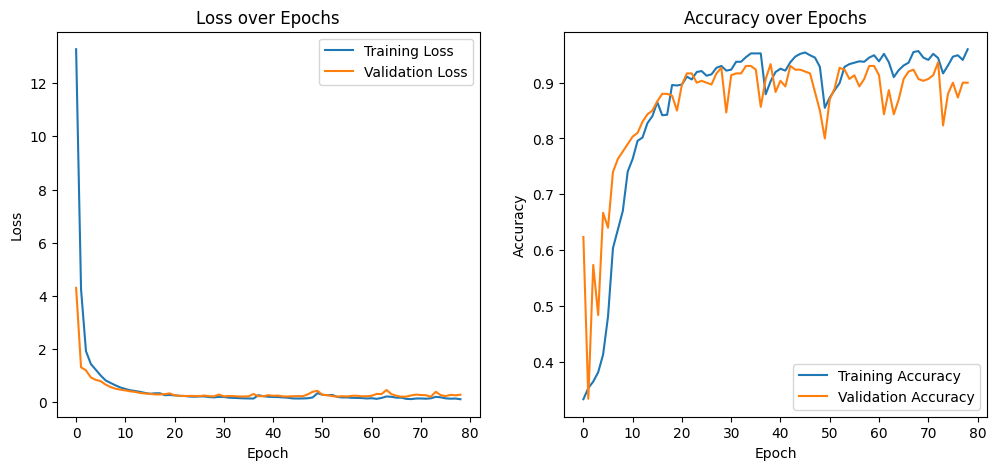

In [18]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Step 3: Optuna

In [19]:
import optuna
from optuna.trial import TrialState

def objective(trial):
    # Reinitialize the model for each trial using the SimpleANN class
    model = SimpleANN(input_size, hidden_sizes, num_classes)  # Initialize the model
    model.to(device)  # Move model to the appropriate device (e.g., GPU)

    # Generate the optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    n_epochs = trial.suggest_int("epochs", 20, 100)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:  # assuming train_loader is defined
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        # Append training statistics to the lists
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:  # assuming val_loader is defined
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_running_loss / len(val_dataset)
        val_acc = val_running_corrects.double() / len(val_dataset)

        # Append validation statistics to the lists
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        trial.report(val_acc, epoch)
        
        # Delay pruning until at least 30 epochs have passed
        if epoch > 30 and trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_acc

# Create study to maximize the accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Get pruned and completed trials
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Output study statistics
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

# Print the best trial
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Print parameters of pruned trials
print("\nPruned trials:")
for trial in pruned_trials:
    print(f"Trial {trial.number} was pruned with the following parameters:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2024-09-29 14:18:06,285] A new study created in memory with name: no-name-4d6206e7-cc9f-4338-b85d-0e08125a858a
[I 2024-09-29 14:18:21,921] Trial 0 finished with value: 0.33666666666666667 and parameters: {'optimizer': 'RMSprop', 'lr': 0.026020817234694793, 'epochs': 91}. Best is trial 0 with value: 0.33666666666666667.
[I 2024-09-29 14:18:37,708] Trial 1 finished with value: 0.8700000000000001 and parameters: {'optimizer': 'RMSprop', 'lr': 0.00011514998047994226, 'epochs': 91}. Best is trial 1 with value: 0.8700000000000001.
[I 2024-09-29 14:18:45,925] Trial 2 finished with value: 0.8600000000000001 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0002528389942765642, 'epochs': 47}. Best is trial 1 with value: 0.8700000000000001.
[I 2024-09-29 14:18:50,967] Trial 3 finished with value: 0.6266666666666667 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0038560287983867413, 'epochs': 29}. Best is trial 1 with value: 0.8700000000000001.
[I 2024-09-29 14:18:57,110] Trial 4 finished wit

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  21
  Number of complete trials:  79
Best trial:
  Value:  0.9333333333333333
  Params: 
    optimizer: Adam
    lr: 0.0003173506339957828
    epochs: 56

Pruned trials:
Trial 7 was pruned with the following parameters:
    optimizer: SGD
    lr: 0.09795549722659602
    epochs: 73
Trial 8 was pruned with the following parameters:
    optimizer: Adam
    lr: 0.0685400303188133
    epochs: 83
Trial 15 was pruned with the following parameters:
    optimizer: Adam
    lr: 0.00032055927202563053
    epochs: 72
Trial 22 was pruned with the following parameters:
    optimizer: Adam
    lr: 0.0020992111248117513
    epochs: 50
Trial 29 was pruned with the following parameters:
    optimizer: SGD
    lr: 0.0004351011831618754
    epochs: 83
Trial 30 was pruned with the following parameters:
    optimizer: RMSprop
    lr: 0.0006378944205774709
    epochs: 52
Trial 34 was pruned with the following parameters:
    opti

In [24]:
import matplotlib.pyplot as plt


# Optimization history plot
plt.figure()
optuna.visualization.plot_optimization_history(study)
plt.show()

# Hyperparameter importance plot
plt.figure()
optuna.visualization.plot_param_importances(study)
plt.show()

# Parallel coordinates plot
plt.figure()
optuna.visualization.plot_parallel_coordinate(study)
plt.show()

# Contour plot
plt.figure()
optuna.visualization.plot_contour(study)
plt.show()

# Slice plot
plt.figure()
optuna.visualization.plot_slice(study)
plt.show()

# Empirical Distribution Function (EDF) plot
plt.figure()
optuna.visualization.plot_edf(study)
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
# Get one batch of training data
train_features, train_labels = next(iter(train_loader))
train_features = train_features.to(device)



# Add the model graph to TensorBoard
writer.add_graph(model, train_features)

In [22]:
# Close the writer when done
writer.close()
# %tensorboard --logdir runs/Chal #Run this in terminal of AAILAB
# #ssh -N -f -L localhost:16007:localhost:6007 minorai4@aailab.avans.nl #RUN THIS IN YOUR OWN CMD/terminal

In [23]:
import shutil
# runs/MNIST/  Here you can delete samples in your MNIST runs.
# shutil.rmtree(defaultDir + 'SGD')


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7bbfa6d2-b0f9-4e27-afe6-e4dcd26ed920' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>